# Least Squares, Uniqueness, and Regularization

Graduate Quantitative Economics and Datascience

Jesse Perla (University of British Columbia)

# Overview

## Motivation

-   In this section we will use some of the previous tools and discuss
    concepts on the curvature of optimization problems
-   Doing so, we will consider uniqueness in optimization problems in
    datascience, economics, and ML
-   Our key optimization problems to consider will be the quadratic
    problems than come out of least squares regressions.
    -   This will provide a foundation for understanding nonlinear
        objectives since we can think of Hessians are locally quadratic.

## Extra Materials

-   [scikit-learn ridge
    regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

## Packages

This section uses the following packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from scipy.linalg import solve_triangular, eigvalsh, cholesky

## First and Second Order Conditions in Optimization

-   For univariate unconstrained optimization $\min_x f(x)$
-   The FONC was $f'(x) = 0$.
    -   But this might not be a valid solution! Or there might be many
-   The second order condition gives us more information and provides
    sufficient conditions
    -   if $f''(x) > 0$, then $x$ is a local minimum; if $f''(x) < 0$,
        then $x$ is a local maximum.
    -   if $f''(x) = 0$ then there may be multiple solutions (locally)

## Related Univariate Conceptsed

-   Recall in your math prep that for a univariate function $f(x)$, we
    have:
    -   $f(x)$ is **convex** if $f''(x) \geq 0$ for all $x$ in the
        domain.
    -   $f(x)$ is **concave** if $f''(x) \leq 0$ for all $x$ in the
        domain.
    -   $f(x)$ is **strictly convex** if $f''(x) > 0$ for all $x$ in the
        domain.
    -   $f(x)$ is **strictly concave** if $f''(x) < 0$ for all $x$ in
        the domain.
-   We will generalize these concepts for thinking about multivariate
    functions
    -   Local behavior, $x'$ such that $|x - x'| < \epsilon$, for some
        $\epsilon$ “balls”

# Definiteness

## Reminder: Positive Definite

In [2]:
A = np.array([[3, 1],
              [1, 2]])
# A_eigs = np.real(eigvals(A)) # symmetric matrices have real eigenvalues
A_eigs = eigvalsh(A) # specialized for symmetric/hermitian matrices
print(A_eigs)
is_positive_definite = np.all(A_eigs > 0)
is_positive_semi_definite = np.all(A_eigs >= 0) # or eigvals(A) >= -eps
print(f"pos-def? {is_positive_definite}")
print(f"pos-semi-def? {is_positive_semi_definite}")

[1.38196601 3.61803399]
pos-def? True
pos-semi-def? True

## Reminder: Positive Definite

In [3]:
A = np.array([[3, -0.5],
              [-0.1, 2]])
# A_eigs = np.real(eigvals(A)) # symmetric matrices have real eigenvalues
A_eigs = eigvalsh(A) # specialized for symmetric/hermitian matrices
print(A_eigs)
is_positive_definite = np.all(A_eigs > 0)
is_positive_semi_definite = np.all(A_eigs >= 0) # or eigvals(A) >= -eps
print(f"pos-def? {is_positive_definite}")
print(f"pos-semi-def? {is_positive_semi_definite}")

[1.99009805 3.00990195]
pos-def? True
pos-semi-def? True

## Reminder: Positive Semi-Definite Matrices

-   The simplest positive-semi-definite (but not posdef) matrix is

In [4]:
A_eigs = eigvalsh(np.array([[1, 0],
                            [0, 0]]))
print(A_eigs)
is_positive_definite = np.all(A_eigs > 0)
is_positive_semi_definite = np.all(A_eigs >= 0) # or eigvals(A) >= -eps
print(f"pos-def? {is_positive_definite}")
print(f"pos-semi-def? {is_positive_semi_definite}")

[0. 1.]
pos-def? False
pos-semi-def? True

## Negative Definite Matrices

-   Simply swap the inequality. Think of a convex vs. concave function

In [5]:
A = -1 * np.array([[3, -0.5],
                   [-0.1, 2]])
A_eigs = eigvalsh(A)
print(A_eigs)
is_negative_definite = np.all(A_eigs < 0)
is_negative_semi_definite = np.all(A_eigs <= 0) # or eigvals(A) >= -eps
print(f"neg-def? {is_negative_definite}, neg-semi-def? {is_negative_semi_definite}")

[-3.00990195 -1.99009805]
neg-def? True, neg-semi-def? True

## Negative Semi-Definite Matrix

-   Semi-definite, but not definite requires the matrix to not be full
    rank
-   At least one zero eigenvalue is necessary and sufficient for a
    matrix to be singular

In [6]:
A = np.array([[-1, -1],
              [-1, -1]])
A_eigs = eigvalsh(A)
print(A_eigs)
is_negative_definite = np.all(A_eigs < 0)
is_negative_semi_definite = np.all(A_eigs <= 0) # or eigvals(A) >= -eps
print(f"neg-def? {is_negative_definite}, neg-semi-def? {is_negative_semi_definite}")

[-2.  0.]
neg-def? False, neg-semi-def? True

# Quadratic Forms

## Quadratic Functions in Higher Dimensions

-   Recall univariate function $f(x) = \frac{a}{2} x^2 + b x + c$ for
    $x \in \mathbb{R}$.
-   General quadratic for $x \in \mathbb{R}^N$ requires cross-terms
    ($a_{12} x_1 x_2, a_{11} x_1^2$ etc.) and linear terms (e.g,
    $b_1 x_1, b_2 x_2$)
-   Can be written as $f(x) = \frac{1}{2} x^{\top} A x + b^{\top} x + c$
    for some symmetric matrix $A$, vector $b$, and scalar $c$

## Gradients of Quadratic Forms

-   Univariate: $f'(x) \equiv \nabla f(x) = a x + b$ and
    $f''(x) \equiv \nabla^2 f(x) = a$
-   Multivariate: $\nabla f(x) = A x + b$ and $\nabla^2 f(x) = A$
    -   $\nabla f(x)$ is the gradient vector at $x$
    -   $\nabla^2 f(x)$ is the Hessian matrix at $x$

## Strict Concavity/Convexity

-   Quadratic functions have the same curvature everywhere, so not $x$
    dependent
-   Univariate:
    -   $a > 0$ is strict convexity
    -   $a < 0$ is strict concavity
    -   $a = 0$ is linear (neither)
-   Multivariate:
    -   $A$ is positive definite is strict convexity, $A$ is negative
        definite is strict concavity.
    -   $A$ is semi-definite weakly convex (maybe strictly in some
        “directions”)
    -   And vice-versa for concavity
-   Recall that the univariate is nested:
    $A = \begin{bmatrix}a\end{bmatrix}$ with eigenvalue $a$

## Shape of Positive Definite Function

-   For $A = \begin{bmatrix} 3 & 1 \\ 1 & 2\end{bmatrix}$
-   This has a **unique minima** (at $(0, 0)$, since no “affine” term,
    $b$)

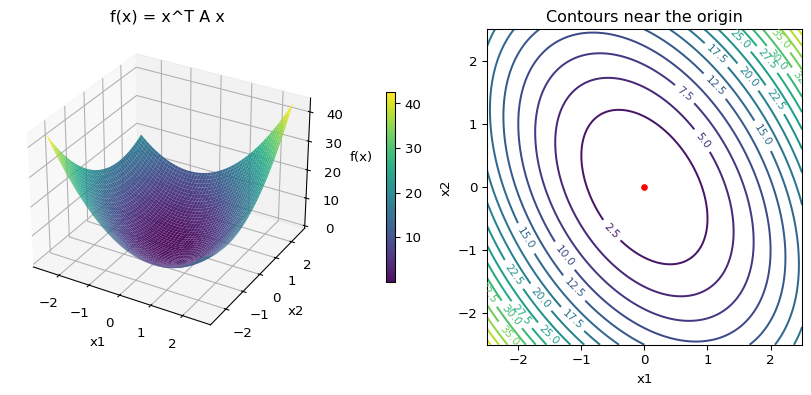

## Shape of Negative Semi-Definite Function

-   For our $A = \begin{bmatrix} -1 & -1 \\ -1 & -1\end{bmatrix}$
-   Note that this **does not** have a unique maximum! All values along
    a line hold
-   Minima rather than maxima since negative rather than positive
    semi-definite

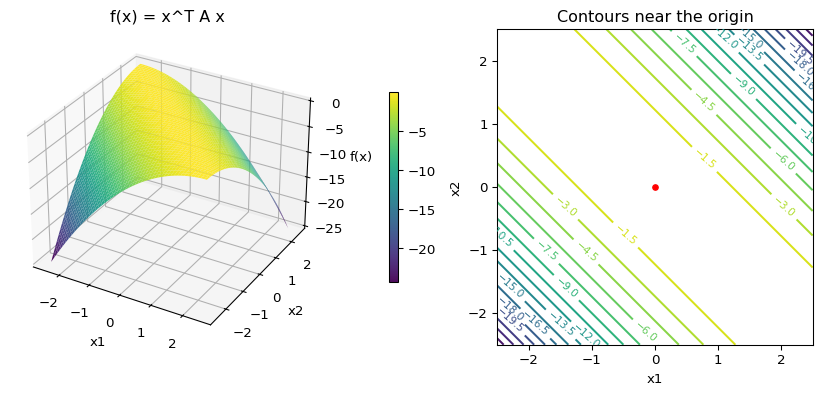

# Least Squares and the Normal Equations

## Least Squares

Given a matrix $X \in \mathbb{R}^{N \times M}$ and a vector
$y \in \mathbb{R}^N$, we want to find $\beta \in \mathbb{R}^M$ such that
$$
\begin{aligned}
\min_{\beta} &||y - X \beta||^2, \text{ that is,}\\
\min_{\beta} &\sum_{n=1}^N \frac{1}{N}(y_n - X_n \cdot \beta)^2
\end{aligned}
$$

Where $X_n$ is n’th row. Take FOCS and rearrange to get

$$
(X^T X) \beta =  X^T y
$$

## Solving the Normal Equations

-   The $X$ is often referred to as the “design matrix”. $X^T X$ as the
    Gram matrix

-   Can form $A = X^T X$ and $b = X^T y$ and solve $A \beta = b$.

    -   Or invert $X^T X$ to get

    $$
    \beta = (X^T X)^{-1} X^T y
    $$

    -   Note that $X^T X$ is symmetric and, if $X$ is full-rank,
        positive definite

## Solving Regression Models in Practice

-   In practice, use the `lstsq` function in scipy
    -   It uses better algorithms using eigenvectors. More stable (see
        next lecture on conditioning)
    -   One algorithm uses another factoring, the QR decomposition
    -   There, $X = Q R$ for $Q$ orthogonal and $R$ upper triangular.
        See [QR
        Decomposition](https://python.quantecon.org/qr_decomp.html) for
        more
-   Better yet, for applied work use higher-level libraries like
    `statsmodels` (integrates well with `pandas` and `seaborn`)
    -   See [statsmodels
        docs](https://www.statsmodels.org/dev/example_formulas.html) for
        R-style notation
    -   See [QuantEcon OLS Notes](https://python.quantecon.org/ols.html)
        for more.

## Example of LLS using Scipy

In [9]:
N, M = 100, 5
X = np.random.randn(N, M)
beta = np.random.randn(M)
y = X @ beta + 0.05 * np.random.randn(N)
beta_hat, residuals, rank, s = scipy.linalg.lstsq(X, y)
print(f"beta =\n {beta}\nbeta_hat =\n{beta_hat}")

beta =
 [-0.24398256  0.01261732 -1.16000953  0.96462878  0.24474327]
beta_hat =
[-0.23758342  0.00900763 -1.15802313  0.95637621  0.24846295]

## Solving using the Normal Equations

Or we can solve it directly. Provide matrix structure (so it can use a
Cholesky)

In [10]:
beta_hat = solve(X.T @ X, X.T @ y, assume_a="pos")
print(f"beta =\n {beta}\nbeta_hat =\n{beta_hat}")

beta =
 [-0.24398256  0.01261732 -1.16000953  0.96462878  0.24474327]
beta_hat =
[-0.23758342  0.00900763 -1.15802313  0.95637621  0.24846295]

## Collinearity in “Tall” Matrices

-   Tall $\mathbb{R}^{N\times M}$ “design matrices” have $N > M$ and are
    “overdetermined”
-   The rank of a matrix is full rank if all columns are linearly
    independent
-   You can only identify $M$ parameters with $M$ linearly independent
    columns

In [11]:
X = np.array([[1, 2], [2, 5], [3, 7]]) # 3 observations, 2 variables
X_col = np.array([[1, 2], [2, 4], [3, 6]]) # all proportional
print(f"rank(X) = {matrix_rank(X)}, rank(X_col) = {matrix_rank(X_col)}")

rank(X) = 2, rank(X_col) = 1

## Collinearity and Estimation

-   If $X$ is not full rank, then $X^T X$ is not invertible. For
    example:

In [12]:
print(f"cond(X'*X)={cond(X.T@X)}, cond(X_col'*X_col)={cond(X_col.T@X_col)}")

cond(X'*X)=2819.332978639814, cond(X_col'*X_col)=1.1014450683078442e+16

-   Note that when you start doing operations on matrices, numerical
    error creeps in, so you will not get an exact number
-   The rule-of-thumb with condition numbers is that if it is
    $1\times 10^k$ then you lose about $k$ digits of precision. So this
    effectively means it is singular
-   Given the singular matrix, this means a continuum of $\beta$ will
    solve the problem

## `lstsq` Solves it? Careful on Interpretation!

-   Since $X_{col}^T X_{col}$ is singular, we cannot use
    `solve(X.T@X, y)`
-   But what about `lstsq` methods?
-   As you will see, this gives an answer. Interpretation is hard
-   The key is that in the case of non-full rank, you cannot identify
    individual parameters
    -   Related to “Identification” in econometrics
    -   Having low residuals is not enough

In [13]:
y = np.array([5.0, 10.1, 14.9])
beta_hat, residuals, rank, s = scipy.linalg.lstsq(X_col, y)
print(f"beta_hat_col = {beta_hat}")
print(f"rank={rank}, cols={X.shape[1]}, norm(X*beta_hat_col-y)={norm(residuals)}")

beta_hat_col = [0.99857143 1.99714286]
rank=1, cols=2, norm(X*beta_hat_col-y)=0.0

## Fat Design Matrices

-   Fat $\mathbb{R}^{N\times M}$ “design matrices” have $N < M$ and are
    “underdetermined”
-   Less common in econometrics, but useful to understand the structure
-   A continuum $\beta\in\mathbb{R}^{M - \text{rank}(X)}$ solve this
    problem

In [14]:
X = np.array([[1, 2, 3], [0, 5, 7]]) # 2 rows, 3 variables
y = np.array([5, 10])
beta_hat, residuals, rank, s = scipy.linalg.lstsq(X, y)
print(f"beta_hat = {beta_hat}, rank={rank}, ? residuals = {residuals}")

beta_hat = [0.8 0.6 1. ], rank=2, ? residuals = []

## Which Solution?

-   Residuals are zero here because there are enough parameters to fit
    perfectly (i.e., it is underdetermined)
-   Given the multiple solutions, the `lstsq` is giving

$$
\min_{\beta} ||\beta||_2^2 \text{ s.t. } X \beta = y
$$

-   i.e., the “smallest” coefficients which interpolate the data exactly
-   Which trivially fulfills the OLS objective:
    $\min_{\beta} ||y - X \beta||_2^2$

## Careful Interpreting Underdetermined Solutions

-   Useful and common in ML, but be **very** careful when interpreting
    for economics
    -   Tight connections to Bayesian versions of statistical tests
    -   But until you understand econometrics and “identification” well,
        **stick to full-rank matrices**
    -   **Advanced topics:** search for “Regularization”, “Ridgeless
        Regression” and “Benign Overfitting in Linear Regression.”

# Regularization

## Recall a Positive Semi-Definite Function

-   For our $A = \begin{bmatrix} 1 & 1 \\ 1 & 1\end{bmatrix}$. Multiple
    minima along a line!

eigenvalues of A: [2. 0.]

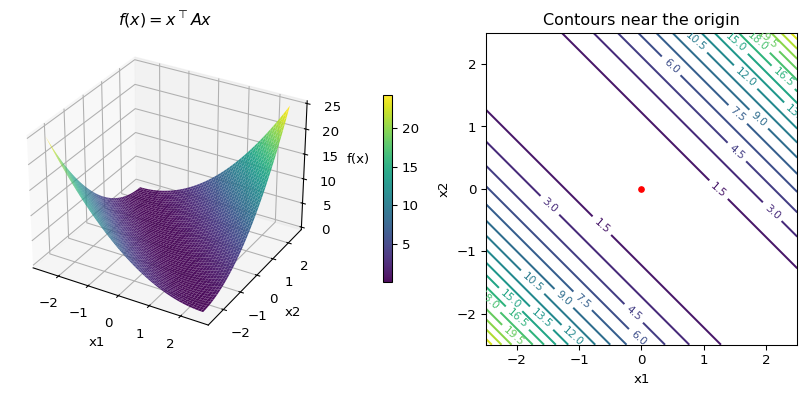

## Fudge the Diagonal?

-   Replace with $A = A + \lambda I$ for $\lambda$ very small (e.g.,
    $1E-5$)
-   Now unique minima at $(0, 0)$

eigenvalues of A: [2.00001e+00 1.00000e-05]

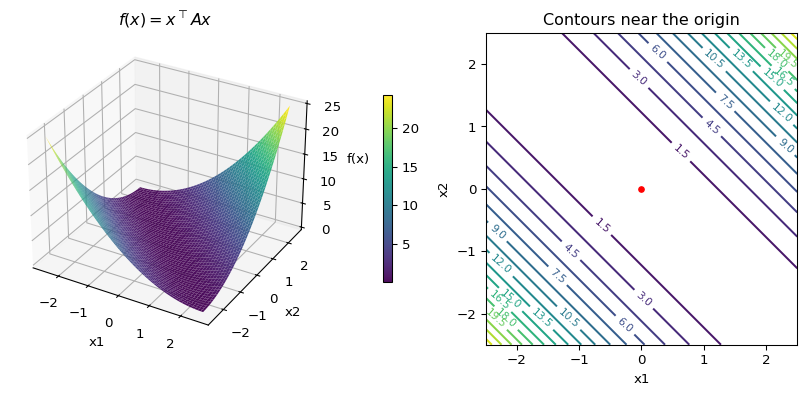

## Motivating this Fudge

-   Previously solved $\min_x\left\{x^{\top} A x\right\}$, which only
    has a unique solution if $A$ is positive definite.
-   Replace with $$
    \min_x\left\{x^{\top} A x+ \lambda ||x||_2^2\right\}
    $$
    -   i.e., penalize solutions by the euclidean length of $x$, called
        a “ridge” term
    -   Could instead penalize by different norms, e.g. $||x||_1$ is
        called LASSO
-   What are the first order conditions? Lets look at least squares

## Ridge Regression

-   More generally, for OLS think of the following $$
    \min_{\beta}\left\{ ||y - X \beta||_2^2 + \lambda ||\beta||_2^2\right\}
    $$
-   Take the FOCs and rearrange to get $$
    (X^{\top} X + \lambda I) \beta =  X^{\top} y
    $$
    -   Note: if $X^{\top}X$ is not full rank (i.e., has a zero
        eigenvalue) then the addition of the $\lambda$ term helps make
        things strictly positive definite
    -   Sometimes you need to do this to overcome nearly collinear data
        or numerical approximations, even when it should be technically
        positive definite

## Ridgeless Regression

-   Recall statement that `lstsq` will return **some** solution even if
    not full rank.
-   We said that in the case where the data could be fit exactly
    -   One can interpret the solution as
        $\min_{\beta} ||\beta||_2^2 \text{ s.t. } X \beta = y$
    -   Interpretation: this is the **min-norm** solution which fits the
        data with the “smallest” $\beta$
-   Can show this is the limit of a ridge regression (i.e., “ridgeless”)
    $$
    \lim_{\lambda \to 0}\min_{\beta}\left\{ ||y - X \beta||_2^2 + \lambda ||\beta||_2^2\right\}
    $$

## Regularization in ML

-   In ML, with rich data sources there are often many possible ways to
    explain the data
-   Economists often avoid this like the plague, and make assumptions to
    ensure perfect identification
    -   Identification arguments ensure positive definiteness of OLS,
        etc.
-   As data becomes richer, it becomes hard to write down models with
    only a single explanation
    -   Regularization lets you bias your solution towards ones with
        certain properties
-   There are Bayesian interpretations of all of these approaches